## STEP 1: INSTALLATION & IMPORTS

In [1]:
# --- 1. Installation ---
# Cài đặt tất cả các thư viện cần thiết.
# -qU: quiet (im lặng), upgrade (nâng cấp)
print("Bắt đầu cài đặt các thư viện...")
!pip install -qU langgraph langchain langchain-core langchain-community groq python-dotenv rich

Bắt đầu cài đặt các thư viện...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bi

In [2]:
# --- 2. Core Imports ---
# Import các thư viện và lớp (class) cốt lõi sẽ được sử dụng trong toàn bộ dự án.
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from google.colab import userdata

# LangChain & LangGraph core components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Groq client for LLM interaction
from groq import AsyncGroq

# Rich library for beautiful printing
from rich.console import Console
from rich.markdown import Markdown

print("\nCài đặt và Import hoàn tất. Môi trường đã sẵn sàng!")


Cài đặt và Import hoàn tất. Môi trường đã sẵn sàng!


## STEP 2: STATE DEFINITION & LLM WRAPPER

In [3]:
# --- 1. State Definition ---
# Định nghĩa cấu trúc cho "bộ nhớ" chung của hệ thống.
# TypedDict giúp chúng ta xác định rõ ràng các trường dữ liệu và kiểu của chúng.
# Điều này giúp code dễ đọc, dễ bảo trì và tránh các lỗi gõ sai tên trường.

def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    """
    Hàm này dùng để hợp nhất (merge) hai dictionary một cách thông minh.
    Thay vì ghi đè, nó sẽ gộp các giá trị lồng nhau.
    Ví dụ: dict1 = {"a": {"x": 1}}, dict2 = {"a": {"y": 2}} -> {"a": {"x": 1, "y": 2}}
    LangGraph sẽ tự động sử dụng hàm này khi cập nhật trạng thái.
    """
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

class AcademicState(TypedDict):
    """
    Đây là "bộ nhớ" trung tâm (Master State) cho toàn bộ hệ thống ATLAS.
    Nó chứa tất cả thông tin mà các agent cần để làm việc và giao tiếp.
    """
    # Lịch sử cuộc trò chuyện giữa người dùng và hệ thống.
    messages: Annotated[List[BaseMessage], operator.add]

    # Thông tin hồ sơ của sinh viên.
    profile: Annotated[Dict, merge_dicts]

    # Thông tin lịch trình, các sự kiện.
    calendar: Annotated[Dict, merge_dicts]

    # Danh sách các công việc, bài tập cần làm.
    tasks: Annotated[Dict, merge_dicts]

    # Nơi lưu trữ kết quả đầu ra từ các agent sau mỗi bước.
    results: Annotated[Dict[str, Any], merge_dicts]

print("Đã định nghĩa 'AcademicState' thành công.")

Đã định nghĩa 'AcademicState' thành công.


In [4]:
# --- 2. LLM Wrapper ---
# Tạo một lớp (class) để bao bọc (wrap) việc giao tiếp với Groq API.
# Điều này giúp code của chúng ta sạch sẽ hơn. Thay vì viết code gọi API lặp đi lặp lại ở nhiều nơi,
# chúng ta chỉ cần gọi một phương thức đơn giản từ lớp này, ví dụ: llm.agenerate(...)

class GroqLLM:
    """
    Lớp này đóng vai trò là "người phiên dịch" giúp giao tiếp với Groq API.
    Nó sử dụng client bất đồng bộ (Async) để không làm block chương trình.
    """
    def __init__(self, api_key: str, model_name: str = "llama3-70b-8192"):
        self.model = model_name
        self.client = AsyncGroq(api_key=api_key)
        print(f"Khởi tạo GroqLLM thành công với model: {self.model}")

    async def agenerate(
        self,
        messages: List[Dict],
        temperature: float = 0.5,
        max_tokens: int = 2048
    ) -> str:
        """
        Gửi yêu cầu đến Groq và nhận lại câu trả lời dưới dạng văn bản.

        Args:
            messages: Danh sách tin nhắn theo định dạng [{ "role": "user", "content": "..." }].
            temperature: Độ "sáng tạo" của câu trả lời (0.0 - 1.0).
            max_tokens: Số lượng token tối đa cho câu trả lời.

        Returns:
            Nội dung câu trả lời của AI (dưới dạng string).
        """
        try:
            completion = await self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
                stream=False  # Chúng ta không cần stream cho ứng dụng này
            )
            return completion.choices[0].message.content
        except Exception as e:
            print(f"Lỗi khi gọi API của Groq: {e}")
            # Trả về một thông báo lỗi để hệ thống có thể xử lý
            return "Đã xảy ra lỗi khi cố gắng giao tiếp với mô hình ngôn ngữ."

In [5]:
# --- 3. Khởi tạo các đối tượng chính ---
# Bây giờ, chúng ta sẽ tạo ra các đối tượng mà toàn bộ hệ thống sẽ sử dụng.

# Lấy API key từ Colab Secrets
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    # Khởi tạo đối tượng LLM
    llm = GroqLLM(api_key=GROQ_API_KEY)
except Exception as e:
    print(f"LỖI: Không thể lấy GROQ_API_KEY từ Colab Secrets. Hãy chắc chắn bạn đã lưu nó ở Bước 1.")
    print(f"Chi tiết lỗi: {e}")
    llm = None # Đặt llm là None nếu có lỗi

# Khởi tạo đối tượng Console để in ra màn hình cho đẹp
console = Console()

if llm:
    print("\nKhởi tạo đối tượng 'llm' và 'console' thành công. Hệ thống đã có 'bộ nhớ' và 'người phiên dịch'.")

Khởi tạo GroqLLM thành công với model: llama3-70b-8192

Khởi tạo đối tượng 'llm' và 'console' thành công. Hệ thống đã có 'bộ nhớ' và 'người phiên dịch'.


## STEP 3: DATA MANAGER

In [6]:
import json
from datetime import datetime, timezone, timedelta
from typing import List, Dict, Optional

class DataManager:
    """
    Quản lý việc tải và truy cập dữ liệu từ các nguồn khác nhau (profile, calendar, tasks).
    Đóng vai trò là một giao diện duy nhất (single source of truth) cho dữ liệu đầu vào.
    """
    def __init__(self):
        """Khởi tạo các vùng chứa dữ liệu. Ban đầu chúng đều trống."""
        self.profile_data: Optional[Dict] = None
        self.calendar_data: Optional[Dict] = None
        self.task_data: Optional[Dict] = None
        print("DataManager đã được khởi tạo.")

    def load_data_from_files(self, profile_path: str, calendar_path: str, task_path: str):
        """
        Tải dữ liệu từ các file JSON được chỉ định.

        Args:
            profile_path (str): Đường dẫn đến file profile.json.
            calendar_path (str): Đường dẫn đến file calendar.json.
            task_path (str): Đường dẫn đến file tasks.json.
        """
        try:
            with open(profile_path, 'r', encoding='utf-8') as f:
                self.profile_data = json.load(f)
            with open(calendar_path, 'r', encoding='utf-8') as f:
                self.calendar_data = json.load(f)
            with open(task_path, 'r', encoding='utf-8') as f:
                self.task_data = json.load(f)
            print("Đã tải thành công dữ liệu từ các file: profile, calendar, tasks.")
            return True
        except FileNotFoundError as e:
            print(f"LỖI: Không tìm thấy file - {e}. Hãy chắc chắn bạn đã tạo file ở Bước 1.")
            return False
        except json.JSONDecodeError as e:
            print(f"LỖI: File JSON không hợp lệ - {e}. Hãy kiểm tra lại nội dung file.")
            return False

    def get_student_profile(self, student_id: str) -> Optional[Dict]:
        """
        Lấy thông tin hồ sơ của một sinh viên cụ thể bằng ID.

        Returns:
            Một dictionary chứa thông tin hồ sơ nếu tìm thấy, ngược lại trả về None.
        """
        if not self.profile_data:
            return None
        # Sử dụng biểu thức generator và next() để tìm kiếm hiệu quả
        return next((p for p in self.profile_data.get("profiles", []) if p.get("id") == student_id), None)

    def _parse_datetime(self, dt_str: str) -> datetime:
        """
        Một hàm nội bộ để phân tích chuỗi ngày tháng, xử lý cả định dạng có và không có 'Z'.
        Luôn chuyển đổi về múi giờ UTC để đảm bảo tính nhất quán.
        """
        # Thay thế 'Z' (Zulu time) bằng offset +00:00 mà Python có thể hiểu
        if dt_str.endswith('Z'):
            dt_str = dt_str[:-1] + '+00:00'
        return datetime.fromisoformat(dt_str).astimezone(timezone.utc)

    def get_upcoming_events(self, days_ahead: int = 7) -> List[Dict]:
        """
        Lấy danh sách các sự kiện sắp diễn ra trong một khoảng thời gian tới.

        Args:
            days_ahead (int): Số ngày tính từ thời điểm hiện tại.

        Returns:
            Một danh sách các sự kiện.
        """
        if not self.calendar_data:
            return []

        now_utc = datetime.now(timezone.utc)
        future_limit = now_utc + timedelta(days=days_ahead)
        upcoming_events = []

        for event in self.calendar_data.get("events", []):
            try:
                start_time_str = event.get("start", {}).get("dateTime")
                if start_time_str:
                    start_time = self._parse_datetime(start_time_str)
                    # Chỉ lấy các sự kiện trong tương lai và trong giới hạn `days_ahead`
                    if now_utc <= start_time <= future_limit:
                        upcoming_events.append(event)
            except (ValueError, KeyError) as e:
                # Bỏ qua các sự kiện có định dạng lỗi và báo warning
                print(f"Warning: Bỏ qua sự kiện bị lỗi định dạng - {event.get('summary', 'N/A')}. Lỗi: {e}")
                continue
        # Sắp xếp các sự kiện theo thứ tự thời gian
        return sorted(upcoming_events, key=lambda e: self._parse_datetime(e['start']['dateTime']))


    def get_active_tasks(self) -> List[Dict]:
        """
        Lấy danh sách các công việc còn hoạt động (chưa hoàn thành và chưa hết hạn).

        Returns:
            Một danh sách các công việc.
        """
        if not self.task_data:
            return []

        now_utc = datetime.now(timezone.utc)
        active_tasks = []

        for task in self.task_data.get("tasks", []):
            try:
                due_str = task.get("due")
                # Chỉ xử lý các task có trạng thái "needsAction" và có ngày hết hạn
                if task.get("status") == "needsAction" and due_str:
                    due_date = self._parse_datetime(due_str)
                    if due_date > now_utc:
                        active_tasks.append(task)
            except (ValueError, KeyError) as e:
                print(f"Warning: Bỏ qua task bị lỗi định dạng - {task.get('title', 'N/A')}. Lỗi: {e}")
                continue
        # Sắp xếp các task theo ngày hết hạn gần nhất
        return sorted(active_tasks, key=lambda t: self._parse_datetime(t['due']))

# --- Thử nghiệm DataManager ---
# Tạo một instance và tải dữ liệu từ các file bạn đã tạo ở Bước 1
data_manager = DataManager()
is_loaded = data_manager.load_data_from_files(
    profile_path="profile.json",
    calendar_path="calendar.json",
    task_path="tasks.json"
)

if is_loaded:
    # In ra để kiểm tra xem nó hoạt động đúng không
    print("\n--- KIỂM TRA DỮ LIỆU ---")
    console.print("[bold green]Hồ sơ sinh viên (student_123):[/bold green]")
    console.print(data_manager.get_student_profile("student_123"))

    console.print("\n[bold green]Các sự kiện sắp tới:[/bold green]")
    console.print(data_manager.get_upcoming_events())

    console.print("\n[bold green]Các công việc đang hoạt động:[/bold green]")
    console.print(data_manager.get_active_tasks())
else:
    console.print("[bold red]Không thể chạy kiểm tra do lỗi tải dữ liệu.[/bold red]")

DataManager đã được khởi tạo.
Đã tải thành công dữ liệu từ các file: profile, calendar, tasks.

--- KIỂM TRA DỮ LIỆU ---


Hồ sơ sinh viên (student_123):

{
    'id': 'student_123',
    'personal_info': {'name': 'An Nguyen', 'major': 'Computer Science', 'academic_year': 3},
    'learning_preferences': {
        'learning_style': {'type': 'Visual', 'details': 'Prefers diagrams, mind maps, and videos.'},
        'study_patterns': {
            'best_time': 'Morning (9 AM - 12 PM)',
            'session_length': '45-minute focus, 15-minute break'
        }
    }
}

Các sự kiện sắp tới:

[
    {
        'summary': 'AI Club Meeting',
        'start': {'dateTime': '2025-08-06T18:00:00Z'},
        'end': {'dateTime': '2025-08-06T19:00:00Z'}
    }
]

Các công việc đang hoạt động:

[
    {
        'id': 'task_02',
        'title': 'Read Chapter 5 - Operating Systems',
        'due': '2025-08-08T23:59:00Z',
        'status': 'needsAction',
        'priority': 'medium'
    },
    {
        'id': 'task_01',
        'title': 'Submit AI project report',
        'due': '2025-08-10T23:59:00Z',
        'status': 'needsAction',
        'priority': 'high'
    }
]

## STEP 4: THE COORDINATOR AGENT
#### Đây là agent đầu tiên và quan trọng nhất, đóng vai trò điều phối.
#### Nó không thực hiện các tác vụ cụ thể như lập kế hoạch hay viết ghi chú,
#### mà thay vào đó, nó phân tích yêu cầu của người dùng để quyết định
#### agent chuyên biệt nào cần được kích hoạt.

In [7]:
import asyncio
from typing import Dict, Any, List

# --- 1. Hàm trợ giúp: Phân tích bối cảnh (analyze_context) ---
# Hàm này thu thập tất cả thông tin liên quan từ trạng thái (state)
# và gói gọn chúng lại để gửi cho LLM.
async def analyze_context(state: AcademicState) -> Dict[str, Any]:
    """
    Phân tích trạng thái hiện tại để tạo ra một bản tóm tắt bối cảnh.
    Bản tóm tắt này giúp LLM hiểu rõ tình hình của sinh viên.
    """
    profile = state.get("profile", {})
    # Sử dụng .get() để tránh lỗi nếu một key nào đó không tồn tại.
    context = {
        "student_major": profile.get("personal_info", {}).get("major", "N/A"),
        "academic_year": profile.get("personal_info", {}).get("academic_year", "N/A"),
        "learning_style": profile.get("learning_preferences", {}).get("learning_style", {}).get("type", "N/A"),
        "preferred_study_time": profile.get("learning_preferences", {}).get("study_patterns", {}).get("best_time", "N/A"),
        "num_upcoming_events": len(state.get("calendar", {}).get("events", [])),
        "num_active_tasks": len(state.get("tasks", {}).get("tasks", []))
    }
    return context

In [8]:
# --- 2. Prompt cho Coordinator Agent ---
# Prompt là "bộ não" của agent. Một prompt tốt sẽ hướng dẫn LLM
# suy nghĩ và trả lời theo đúng cách chúng ta muốn.
COORDINATOR_PROMPT = """
Bạn là một Coordinator Agent bậc thầy trong hệ thống hỗ trợ học tập ATLAS.
Nhiệm vụ của bạn KHÔNG phải là trả lời trực tiếp yêu cầu của người dùng, mà là phân tích yêu cầu đó và quyết định agent nào cần được kích hoạt để xử lý.

CÁC AGENT CÓ SẴN:
- PLANNER: Chuyên gia lập kế hoạch, quản lý lịch trình và công việc. Kích hoạt khi yêu cầu liên quan đến lịch, thời gian, deadline, tạo kế hoạch.
- NOTEWRITER: Chuyên gia tạo ghi chú, tóm tắt tài liệu, bài giảng. Kích hoạt khi yêu cầu liên quan đến việc tạo tài liệu học tập, tóm tắt, ghi chú.
- ADVISOR: Chuyên gia tư vấn chiến lược học tập, đưa ra lời khuyên. Kích hoạt khi yêu cầu cần lời khuyên về phương pháp học, cách đối mặt với khó khăn.

BỐI CẢNH HIỆN TẠI CỦA SINH VIÊN:
{context}

YÊU CẦU CỦA SINH VIÊN:
"{request}"

DỰA VÀO BỐI CẢNH VÀ YÊU CẦU, hãy thực hiện các bước sau:
1.  **Reasoning (Lý luận):** Suy nghĩ từng bước để phân tích yêu cầu. Người dùng thực sự cần gì? Vấn đề cốt lõi là gì?
2.  **Decision (Quyết định):** Dựa trên lý luận, quyết định danh sách các agent cần thiết.

HÃY TRẢ LỜI THEO ĐỊNH DẠNG JSON CHÍNH XÁC NHƯ SAU, KHÔNG THÊM BẤT KỲ GIẢI THÍCH NÀO KHÁC:
{{
  "reasoning": "...",
  "required_agents": ["AGENT_1", "AGENT_2", ...]
}}
"""

In [9]:
# --- 3. Hàm trợ giúp: Phân tích phản hồi của AI (parse_coordinator_response) ---
# Hàm này lấy chuỗi JSON trả về từ LLM và chuyển nó thành một dictionary Python.
def parse_coordinator_response(response_str: str) -> Dict[str, Any]:
    """
    Phân tích chuỗi trả lời của LLM để lấy ra thông tin có cấu trúc.
    Có xử lý lỗi nếu LLM trả về không đúng định dạng JSON.
    """
    try:
        # Tìm và trích xuất nội dung JSON từ trong chuỗi
        json_match = response_str[response_str.find('{'):response_str.rfind('}')+1]
        parsed_json = json.loads(json_match)
        # Đảm bảo key 'required_agents' luôn tồn tại và là một list
        if "required_agents" not in parsed_json or not isinstance(parsed_json["required_agents"], list):
            parsed_json["required_agents"] = ["PLANNER"] # Mặc định là PLANNER nếu có lỗi
        return parsed_json
    except (json.JSONDecodeError, IndexError):
        print("Warning: Không thể phân tích phản hồi từ Coordinator. Sử dụng agent mặc định là PLANNER.")
        # Nếu có lỗi, trả về một cấu trúc mặc định an toàn
        return {
            "reasoning": "Lỗi phân tích phản hồi. Mặc định kích hoạt Planner.",
            "required_agents": ["PLANNER"]
        }

In [10]:
# --- 4. Hàm Agent chính: coordinator_agent ---
# Đây là hàm sẽ được đăng ký làm một "nút" (node) trong đồ thị LangGraph.
async def coordinator_agent(state: AcademicState) -> Dict[str, Any]:
    """
    Thực thi logic của Coordinator Agent.
    """
    print("\n--- Bắt đầu chạy Coordinator Agent ---")
    try:
        # 1. Thu thập bối cảnh
        context = await analyze_context(state)
        # 2. Lấy yêu cầu gần nhất của người dùng
        request = state["messages"][-1].content

        # 3. Tạo prompt hoàn chỉnh
        prompt = COORDINATOR_PROMPT.format(
            context=json.dumps(context, indent=2, ensure_ascii=False),
            request=request
        )

        # 4. Gửi yêu cầu đến LLM
        print("Gửi yêu cầu đến LLM để phân tích...")
        response_str = await llm.agenerate([
            {"role": "user", "content": prompt}
        ])
        print("Đã nhận phản hồi từ LLM.")
        console.print("[yellow]Phản hồi thô từ LLM:[/yellow]")
        console.print(response_str)

        # 5. Phân tích phản hồi
        analysis_result = parse_coordinator_response(response_str)
        print("Đã phân tích phản hồi thành công.")

        # 6. Trả về kết quả để cập nhật vào trạng thái chung
        # Kết quả sẽ được lưu vào state['results']['coordinator_analysis']
        return {
            "results": {
                "coordinator_analysis": analysis_result
            }
        }

    except Exception as e:
        print(f"LỖI nghiêm trọng trong Coordinator Agent: {e}")
        # Trong trường hợp có lỗi không lường trước, vẫn trả về một cấu trúc an toàn
        return {
            "results": {
                "coordinator_analysis": {
                    "reasoning": f"Lỗi hệ thống: {e}",
                    "required_agents": ["PLANNER"]
                }
            }
        }

In [12]:
# --- 5. Thử nghiệm Agent ---
# Do Google Colab đã chạy sẵn một event loop, chúng ta không thể dùng asyncio.run().
# Thay vào đó, chúng ta sẽ dùng `await` trực tiếp nếu đang ở trong môi trường notebook.

async def test_coordinator():
    # Giả lập một trạng thái ban đầu
    initial_state = {
        "messages": [HumanMessage(content="Tôi có một bài tập lớn AI sắp hết hạn và một kỳ thi vào tuần tới. Hãy giúp tôi tạo một kế hoạch và một vài ghi chú tóm tắt cho các chủ đề chính.")],
        "profile": data_manager.get_student_profile("student_123"),
        "calendar": {"events": data_manager.get_upcoming_events()},
        "tasks": {"tasks": data_manager.get_active_tasks()},
        "results": {}
    }

    # Chạy coordinator_agent với trạng thái giả lập
    coordinator_result = await coordinator_agent(initial_state)

    # In kết quả phân tích ra màn hình
    console.print("\n--- KẾT QUẢ PHÂN TÍCH CỦA COORDINATOR ---")
    console.print(coordinator_result['results']['coordinator_analysis'])


print("Bắt đầu thử nghiệm Coordinator Agent một cách độc lập...")
# Chỉ chạy nếu llm đã được khởi tạo thành công ở bước trước
if llm:
    # Trong Colab, bạn có thể `await` trực tiếp ở cấp cao nhất của một ô code.
    # Colab sẽ tự động chạy nó trên event loop có sẵn.
    # Để chắc chắn, chúng ta có thể thêm một trình bao bọc nhỏ.
    await test_coordinator()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì đối tượng 'llm' chưa được khởi tạo.[/bold red]")

Bắt đầu thử nghiệm Coordinator Agent một cách độc lập...

--- Bắt đầu chạy Coordinator Agent ---
Gửi yêu cầu đến LLM để phân tích...
Đã nhận phản hồi từ LLM.


Phản hồi thô từ LLM:

{
  "reasoning": "The student needs help with creating a plan and taking notes for an upcoming AI assignment and 
exam. The core issue is managing time and prioritizing tasks to meet deadlines.",
  "required_agents": ["PLANNER", "NOTEWRITER"]
}

Đã phân tích phản hồi thành công.


--- KẾT QUẢ PHÂN TÍCH CỦA COORDINATOR ---

{
    'reasoning': 'The student needs help with creating a plan and taking notes for an upcoming AI assignment and 
exam. The core issue is managing time and prioritizing tasks to meet deadlines.',
    'required_agents': ['PLANNER', 'NOTEWRITER']
}

## STEP 5: THE PLANNER AGENT
#### Nó chứa một quy trình làm việc nội bộ (subgraph) để thực hiện các tác vụ phức tạp.

In [14]:
# --- 1. Định nghĩa Lớp PlannerAgent ---
class PlannerAgent:
    """
    Agent chuyên xử lý mọi thứ liên quan đến lập kế hoạch, lịch trình và công việc.
    """
    def __init__(self, llm_instance: GroqLLM):
        """Khởi tạo agent với một instance của LLM."""
        self.llm = llm_instance
        print("PlannerAgent đã được khởi tạo.")

    async def calendar_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút đầu tiên trong subgraph của Planner: Phân tích lịch trình.
        """
        print("\n--- [Planner] Bắt đầu phân tích Lịch trình (calendar_analyzer) ---")
        # Lấy dữ liệu cần thiết từ trạng thái
        events = state["calendar"].get("events", [])
        request = state["messages"][-1].content

        prompt = f"""
        Bạn là một trợ lý phân tích lịch trình. Dựa vào danh sách các sự kiện dưới đây và yêu cầu của người dùng, hãy đưa ra một bản phân tích ngắn gọn.

        YÊU CẦU NGƯỜI DÙNG: "{request}"

        DANH SÁCH SỰ KIỆN:
        {json.dumps(events, indent=2, ensure_ascii=False)}

        HÃY PHÂN TÍCH VÀ TRẢ LỜI:
        - Các khoảng thời gian trống chính.
        - Các xung đột tiềm tàng hoặc những ngày bận rộn.
        - Mức độ áp lực về lịch trình (cao, trung bình, thấp).
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích lịch trình:[/cyan]", response)

        # Trả về kết quả để hợp nhất vào state['results']['calendar_analysis']
        return {"results": {"calendar_analysis": {"analysis_text": response}}}


    async def task_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút thứ hai trong subgraph của Planner: Phân tích công việc.
        """
        print("\n--- [Planner] Bắt đầu phân tích Công việc (task_analyzer) ---")
        tasks = state["tasks"].get("tasks", [])
        request = state["messages"][-1].content

        prompt = f"""
        Bạn là một trợ lý phân tích công việc. Dựa vào danh sách công việc và yêu cầu của người dùng, hãy đưa ra một bản phân tích ngắn gọn.

        YÊU CẦU NGƯỜI DÙNG: "{request}"

        DANH SÁCH CÔNG VIỆC:
        {json.dumps(tasks, indent=2, ensure_ascii=False)}

        HÃY PHÂN TÍCH VÀ TRẢ LỜI:
        - Công việc nào cần được ưu tiên nhất và tại sao.
        - Mức độ áp lực về công việc (cao, trung bình, thấp).
        - Các deadline gần nhất cần chú ý.
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích công việc:[/cyan]", response)
        return {"results": {"task_analysis": {"analysis_text": response}}}


    async def plan_generator(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút cuối cùng: Tổng hợp tất cả các phân tích để tạo ra kế hoạch cuối cùng.
        """
        print("\n--- [Planner] Bắt đầu tạo Kế hoạch (plan_generator) ---")
        # Thu thập tất cả các "nguyên liệu"
        request = state["messages"][-1].content
        profile = state.get("profile", {})
        calendar_analysis = state.get("results", {}).get("calendar_analysis", "Không có phân tích lịch trình.")
        task_analysis = state.get("results", {}).get("task_analysis", "Không có phân tích công việc.")

        prompt = f"""
        Bạn là một chuyên gia lập kế hoạch học tập siêu hạng. Nhiệm vụ của bạn là tạo ra một bản kế hoạch CHI TIẾT và DỄ THỰC HIỆN cho sinh viên.

        DỰA VÀO TẤT CẢ CÁC THÔNG TIN DƯỚI ĐÂY:

        1.  **YÊU CẦU CỦA SINH VIÊN:**
            "{request}"

        2.  **HỒ SƠ SINH VIÊN:**
            {json.dumps(profile, indent=2, ensure_ascii=False)}

        3.  **PHÂN TÍCH LỊCH TRÌNH CỦA BẠN:**
            {json.dumps(calendar_analysis, indent=2, ensure_ascii=False)}

        4.  **PHÂN TÍCH CÔNG VIỆC CỦA BẠN:**
            {json.dumps(task_analysis, indent=2, ensure_ascii=False)}

        HÃY TẠO RA MỘT BẢN KẾ HOẠCH HOÀN CHỈNH. Bản kế hoạch nên bao gồm:
        - Một lịch trình gợi ý theo từng ngày hoặc buổi.
        - Các chiến lược cụ thể để giải quyết công việc.
        - Lời khuyên về việc cân bằng giữa học tập và các hoạt động khác.
        - Sử dụng giọng văn thân thiện, động viên.
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.7)
        console.print("[bold green]Kế hoạch cuối cùng đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_plan": {"plan_text": response}}}


    def create_subgraph(self) -> StateGraph:
        """
        Tạo và trả về đồ thị con (subgraph) cho riêng PlannerAgent.
        """
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("calendar_analyzer", self.calendar_analyzer)
        subgraph.add_node("task_analyzer", self.task_analyzer)
        subgraph.add_node("plan_generator", self.plan_generator)

        # Định nghĩa luồng đi: analyzer -> task_analyzer -> plan_generator
        subgraph.add_edge("calendar_analyzer", "task_analyzer")
        subgraph.add_edge("task_analyzer", "plan_generator")

        # Điểm bắt đầu của subgraph này là calendar_analyzer
        subgraph.set_entry_point("calendar_analyzer")
        # Điểm kết thúc là plan_generator (sau khi chạy xong sẽ tự động kết thúc)
        subgraph.add_edge("plan_generator", END)

        return subgraph.compile()


In [15]:
# --- 2. Thử nghiệm PlannerAgent ---
async def test_planner_agent():
    # Khởi tạo Planner Agent
    planner = PlannerAgent(llm)
    # Tạo subgraph của nó
    planner_workflow = planner.create_subgraph()

    # Giả lập một trạng thái ban đầu (như là đã chạy qua Coordinator)
    initial_state_for_planner = {
        "messages": [HumanMessage(content="Tôi có một bài tập lớn AI sắp hết hạn và một kỳ thi vào tuần tới. Hãy giúp tôi tạo một kế hoạch chi tiết.")],
        "profile": data_manager.get_student_profile("student_123"),
        "calendar": {"events": data_manager.get_upcoming_events()},
        "tasks": {"tasks": data_manager.get_active_tasks()},
        "results": {
            # Giả sử Coordinator đã chạy và đưa ra kết quả này
            "coordinator_analysis": {
                "reasoning": "Yêu cầu cần một kế hoạch chi tiết.",
                "required_agents": ["PLANNER"]
            }
        }
    }

    print("\n--- BẮT ĐẦU THỬ NGHIỆM PLANNER AGENT SUBGRAPH ---")
    # Chạy toàn bộ workflow của Planner
    final_planner_state = await planner_workflow.ainvoke(initial_state_for_planner)

    console.print("\n--- KẾT QUẢ CUỐI CÙNG TỪ PLANNER AGENT ---")
    # In ra kế hoạch cuối cùng từ trạng thái kết quả
    console.print(Markdown(final_planner_state['results']['final_plan']['plan_text']))


# Chạy hàm test nếu llm đã được khởi tạo
if llm:
    await test_planner_agent()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì đối tượng 'llm' chưa được khởi tạo.[/bold red]")

PlannerAgent đã được khởi tạo.

--- BẮT ĐẦU THỬ NGHIỆM PLANNER AGENT SUBGRAPH ---

--- [Planner] Bắt đầu phân tích Lịch trình (calendar_analyzer) ---


Phân tích lịch trình: Based on the user's request and the event list, here is a brief analysis:

**Main Time Blocks:**

* The user has a large AI assignment due soon and an exam next week, which means they need to allocate significant 
time for studying and working on the assignment.
* There is an AI Club Meeting on August 6th from 18:00 to 19:00, which will take up 1 hour of their time.

**Potential Conflicts or Busy Days:**

* The user has a critical exam next week, which may require intense studying and preparation in the coming days.
* The AI assignment deadline is approaching, which may cause stress and impact their schedule.

**Schedule Pressure Level:**

* High: The user has a significant assignment and an exam coming up, which will require a lot of time and effort. 
The AI Club Meeting on August 6th is an additional commitment that may add to their schedule pressure.

Recommendation: The user should prioritize their time and focus on studying for the exam and working on the AI 
assignment. They should also consider rescheduling or adjusting the AI Club Meeting if possible, to ensure they 
have sufficient time for their critical tasks.


--- [Planner] Bắt đầu phân tích Công việc (task_analyzer) ---


Phân tích công việc: Based on the provided task list and user request, here is a brief analysis:

**Priority Task:** "Submit AI project report" (task_01) with a high priority and a deadline of August 10th, 2025. 
This task should be prioritized because it has a high priority level and a nearing deadline, which is critical for 
the user's upcoming exam.

**Workload Pressure:** Medium to High. The user has two tasks with nearing deadlines, which may cause some 
pressure. However, the tasks seem manageable if the user creates a focused plan to tackle them.

**Upcoming Deadlines:** August 8th, 2025 (Read Chapter 5 - Operating Systems) and August 10th, 2025 (Submit AI 
project report). The user should focus on completing the AI project report by August 10th, and then allocate time 
to read Chapter 5 before the deadline.

To create a detailed plan, I recommend the following:

1. Allocate dedicated time to work on the AI project report, ensuring its completion by August 10th.
2. Set aside a few hours to read Chapter 5 - Operating Systems before August 8th.
3. Create a study schedule for the upcoming exam, incorporating time for reviewing the Operating Systems chapter 
and other relevant materials.

By following this plan, the user should be able to manage their workload and meet the deadlines, while also feeling
prepared for the upcoming exam.


--- [Planner] Bắt đầu tạo Kế hoạch (plan_generator) ---


Kế hoạch cuối cùng đã được tạo:

An's AI Project and Exam Prep Plan                                                                                 

Hey An!                                                                                                            

I've got a customized plan to help you tackle your AI project and exam prep. This plan takes into account your     
learning preferences, schedule, and task list. Let's get started!                                                  

Week of August 3rd - 10th                                                                                          

Day 1-2 (August 3rd-4th): AI Project Report Focus                                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Work on AI project report (45-minute focus + 15-minute break)            
 • Afternoon sessions (1:00 PM - 3:00 PM): Continue working on AI project report                                   
 • Break: Take a 30-minute walk or do some stretching exercises to refresh your mind                               

Day 3 (August 5th): Operating Systems Chapter Review                                                               

 • Morning sessions (9:00 AM - 12:00 PM): Read Chapter 5 - Operating Systems (45-minute focus + 15-minute break)   
 • Afternoon sessions (1:00 PM - 3:00 PM): Review notes and summarize key points                                   
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 4 (August 6th): AI Club Meeting and Exam Prep                                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Review AI project report progress and make adjustments                   
 • 18:00 - 19:00: Attend AI Club Meeting                                                                           
 • Afternoon sessions (7:00 PM - 9:00 PM): Begin reviewing exam materials (45-minute focus + 15-minute break)      

Day 5-6 (August 7th-8th): Exam Prep and AI Project Report                                                          

 • Morning sessions (9:00 AM - 12:00 PM): Focus on exam prep (45-minute focus + 15-minute break)                   
 • Afternoon sessions (1:00 PM - 3:00 PM): Work on AI project report                                               
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 7 (August 9th): Exam Prep and Review                                                                           

 • Morning sessions (9:00 AM - 12:00 PM): Intensive exam prep (45-minute focus + 15-minute break)                  
 • Afternoon sessions (1:00 PM - 3:00 PM): Review entire course material and practice problems                     
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 8 (August 10th): Submit AI Project Report and Final Exam Prep                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Finalize AI project report and submit                                    
 • Afternoon sessions (1:00 PM - 3:00 PM): Last-minute exam prep and review                                        
 • Break: Take a 30-minute break to relax and recharge before the exam                                             

Additional Tips and Reminders:                                                                                     

 • Make sure to take breaks and stay hydrated throughout the day.                                                  
 • Use diagrams, mind maps, and videos to help you understand complex concepts.                                    
 • Prioritize your tasks and focus on the most critical ones first.                                                
 • Don't hesitate to reach out to your instructor or classmates if you need help or clarification on any topics.   

Balancing Study and Other Activities: 

--- KẾT QUẢ CUỐI CÙNG TỪ PLANNER AGENT ---

An's AI Project and Exam Prep Plan                                                                                 

Hey An!                                                                                                            

I've got a customized plan to help you tackle your AI project and exam prep. This plan takes into account your     
learning preferences, schedule, and task list. Let's get started!                                                  

Week of August 3rd - 10th                                                                                          

Day 1-2 (August 3rd-4th): AI Project Report Focus                                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Work on AI project report (45-minute focus + 15-minute break)            
 • Afternoon sessions (1:00 PM - 3:00 PM): Continue working on AI project report                                   
 • Break: Take a 30-minute walk or do some stretching exercises to refresh your mind                               

Day 3 (August 5th): Operating Systems Chapter Review                                                               

 • Morning sessions (9:00 AM - 12:00 PM): Read Chapter 5 - Operating Systems (45-minute focus + 15-minute break)   
 • Afternoon sessions (1:00 PM - 3:00 PM): Review notes and summarize key points                                   
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 4 (August 6th): AI Club Meeting and Exam Prep                                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Review AI project report progress and make adjustments                   
 • 18:00 - 19:00: Attend AI Club Meeting                                                                           
 • Afternoon sessions (7:00 PM - 9:00 PM): Begin reviewing exam materials (45-minute focus + 15-minute break)      

Day 5-6 (August 7th-8th): Exam Prep and AI Project Report                                                          

 • Morning sessions (9:00 AM - 12:00 PM): Focus on exam prep (45-minute focus + 15-minute break)                   
 • Afternoon sessions (1:00 PM - 3:00 PM): Work on AI project report                                               
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 7 (August 9th): Exam Prep and Review                                                                           

 • Morning sessions (9:00 AM - 12:00 PM): Intensive exam prep (45-minute focus + 15-minute break)                  
 • Afternoon sessions (1:00 PM - 3:00 PM): Review entire course material and practice problems                     
 • Break: Take a 30-minute break to relax and recharge                                                             

Day 8 (August 10th): Submit AI Project Report and Final Exam Prep                                                  

 • Morning sessions (9:00 AM - 12:00 PM): Finalize AI project report and submit                                    
 • Afternoon sessions (1:00 PM - 3:00 PM): Last-minute exam prep and review                                        
 • Break: Take a 30-minute break to relax and recharge before the exam                                             

Additional Tips and Reminders:                                                                                     

 • Make sure to take breaks and stay hydrated throughout the day.                                                  
 • Use diagrams, mind maps, and videos to help you understand complex concepts.                                    
 • Prioritize your tasks and focus on the most critical ones first.                                                
 • Don't hesitate to reach out to your instructor or classmates if you need help or clarification on any topics.   

Balancing Study and Other Activities: 

## STEP 6: THE NOTEWRITER AGENT
#### Agent này chuyên về việc xử lý nội dung, tạo ghi chú và tóm tắt tài liệu.
#### Nó cũng có một subgraph nội bộ riêng

In [16]:
# --- 1. Định nghĩa Lớp NoteWriterAgent ---
class NoteWriterAgent:
    """
    Agent chuyên tạo ra các tài liệu học tập được cá nhân hóa.
    """
    def __init__(self, llm_instance: GroqLLM):
        self.llm = llm_instance
        print("NoteWriterAgent đã được khởi tạo.")

    async def learning_style_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút đầu tiên trong subgraph: Phân tích phong cách học tập và yêu cầu.
        """
        print("\n--- [NoteWriter] Bắt đầu phân tích Phong cách học tập ---")
        profile = state.get("profile", {})
        request = state["messages"][-1].content
        learning_style = profile.get("learning_preferences", {}).get("learning_style", {})

        prompt = f"""
Bạn là một trợ lý phân tích giáo dục. Dựa vào hồ sơ và yêu cầu của sinh viên, hãy xác định phương pháp tạo ghi chú tốt nhất.

YÊU CẦU CỦA SINH VIÊN: "{request}"

HỒ SƠ PHONG CÁCH HỌC:
{json.dumps(learning_style, indent=2, ensure_ascii=False)}

HÃY PHÂN TÍCH VÀ ĐƯA RA KẾT LUẬN NGẮN GỌN:
- Sinh viên này phù hợp với loại ghi chú nào nhất (ví dụ: gạch đầu dòng chi tiết, mind map, flashcards, tóm tắt dạng kể chuyện)?
- Những điểm chính cần tập trung khi tạo ghi chú cho họ là gì?
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích phong cách học tập:[/cyan]", response)
        return {"results": {"learning_style_analysis": {"analysis_text": response}}}


    async def notes_generator(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút thứ hai: Tạo ra bản ghi chú cuối cùng.
        """
        print("\n--- [NoteWriter] Bắt đầu tạo Ghi chú ---")
        request = state["messages"][-1].content
        learning_style_analysis = state.get("results", {}).get("learning_style_analysis", "Không có phân tích.")

        prompt = f"""
Bạn là một chuyên gia tạo ghi chú học thuật. Nhiệm vụ của bạn là tạo ra một bản ghi chú súc tích, dễ hiểu và hiệu quả.

DỰA VÀO CÁC THÔNG TIN SAU:

1.  **YÊU CẦU CỦA SINH VIÊN:**
    "{request}"

2.  **PHÂN TÍCH VỀ PHONG CÁCH HỌC TẬP:**
    {json.dumps(learning_style_analysis, indent=2, ensure_ascii=False)}

HÃY TẠO RA MỘT BẢN GHI CHÚ TÓM TẮT.
- Giả sử bạn đã có toàn bộ kiến thức về chủ đề được yêu cầu (ví dụ: "các chủ đề chính của AI").
- Tập trung vào việc trình bày thông tin theo cách phù hợp nhất với phân tích ở trên.
- Sử dụng định dạng Markdown để trình bày rõ ràng (tiêu đề, gạch đầu dòng, in đậm).
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.6)
        console.print("[bold green]Ghi chú cuối cùng đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_notes": {"notes_text": response}}}


    def create_subgraph(self) -> StateGraph:
        """
        Tạo và trả về đồ thị con (subgraph) cho riêng NoteWriterAgent.
        """
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("learning_style_analyzer", self.learning_style_analyzer)
        subgraph.add_node("notes_generator", self.notes_generator)

        subgraph.add_edge("learning_style_analyzer", "notes_generator")
        subgraph.set_entry_point("learning_style_analyzer")
        subgraph.add_edge("notes_generator", END)

        return subgraph.compile()




In [17]:
# --- 2. Thử nghiệm NoteWriterAgent ---
async def test_notewriter_agent():
    # Khởi tạo NoteWriter Agent
    notewriter = NoteWriterAgent(llm)
    # Tạo subgraph của nó
    notewriter_workflow = notewriter.create_subgraph()

    # Giả lập một trạng thái ban đầu
    initial_state_for_notewriter = {
        "messages": [HumanMessage(content="Hãy tóm tắt giúp tôi các chủ đề chính trong lĩnh vực AI cho kỳ thi sắp tới. Tôi là người học bằng hình ảnh.")],
        "profile": data_manager.get_student_profile("student_123"),
        # Các trường khác có thể để trống vì NoteWriter không cần chúng
        "calendar": {},
        "tasks": {},
        "results": {}
    }

    print("\n--- BẮT ĐẦU THỬ NGHIỆM NOTEWRITER AGENT SUBGRAPH ---")
    # Chạy toàn bộ workflow của NoteWriter
    final_notewriter_state = await notewriter_workflow.ainvoke(initial_state_for_notewriter)

    console.print("\n--- KẾT QUẢ CUỐI CÙNG TỪ NOTEWRITER AGENT ---")
    console.print(Markdown(final_notewriter_state['results']['final_notes']['notes_text']))

# Chạy hàm test nếu llm đã được khởi tạo
if llm:
    await test_notewriter_agent()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì đối tượng 'llm' chưa được khởi tạo.[/bold red]")

NoteWriterAgent đã được khởi tạo.

--- BẮT ĐẦU THỬ NGHIỆM NOTEWRITER AGENT SUBGRAPH ---

--- [NoteWriter] Bắt đầu phân tích Phong cách học tập ---


Phân tích phong cách học tập: Based on the student's profile and requirements, I would recommend the following:

**Most suitable note-taking method:** Mind Map

The student's preference for visual learning and their fondness for diagrams and mind maps make mind mapping an 
ideal note-taking method for them. Mind maps allow for visual organization of information, creating connections 
between ideas and concepts, which would help the student to better understand and retain complex AI concepts.

**Key focus areas when creating notes for this student:**

1. **Visual representation**: Incorporate diagrams, flowcharts, and other visual aids to help the student 
understand and retain information.
2. **Hierarchical organization**: Use mind maps or concept maps to organize information in a hierarchical 
structure, making it easier for the student to see relationships between concepts.
3. **Key concept identification**: Highlight and emphasize key concepts and terms in AI, using visual cues such as 
bold text, colors, or icons.
4. **Use of images and videos**: Incorporate relevant images and videos to supplement text-based information, 
making it more engaging and memorable for the student.
5. **Summarization and condensation**: Focus on summarizing complex concepts into concise, easy-to-understand 
points, using visual aids to support the summary.

By following these guidelines, the student will be able to effectively review and retain the main concepts in AI, 
preparing them well for their upcoming exam.


--- [NoteWriter] Bắt đầu tạo Ghi chú ---


Ghi chú cuối cùng đã được tạo:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                   AI Exam Prep: Key Concepts and Visual Notes                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                 Machine Learning                                                  

                                                Supervised Learning                                                

 • Definition: Training a model on labeled data to make predictions on new data                                    
 • Types:                                                                                                          
    • Regression (predict continuous values)                                                                       
    • Classification (predict categorical values)                                                                  
 • Algorithms:                                                                                                     
    • Linear Regression                                                                                            
    • Decision Trees                                                                                               
    • Random Forest                                                                                                
    • Support Vector Machines (SVM)                                                                                

                                               Unsupervised Learning                                               

 • Definition: Training a model on unlabeled data to discover patterns and relationships                           
 • Types:                                                                                                          
    • Clustering (group similar data points)                                                                       
    • Dimensionality Reduction (reduce data complexity)                                                            
 • Algorithms:                                                                                                     
    • K-Means Clustering                                                                                           
    • Hierarchical Clustering                                                                                      
    • Principal Component Analysis (PCA)                                                                           


                                                   Deep Learning                                                   

                                                  Neural Networks                                                  

 • Definition: A model composed of multiple layers of interconnected nodes (neurons)                               
 • Types:                                                                                                          
    • Feedforward Networks                                                                                         
    • Recurrent Neural Networks (RNN)                                                                              
    • Convolutional Neural Networks (CNN)                                                                          
 • Applications:                                                                                                   
    • Image Recognition                                                                                            
    • Natural Language Processing (NLP)                                                                            
    • Speech Recognition                                                                                           

                                        Convo

--- KẾT QUẢ CUỐI CÙNG TỪ NOTEWRITER AGENT ---

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                   AI Exam Prep: Key Concepts and Visual Notes                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                 Machine Learning                                                  

                                                Supervised Learning                                                

 • Definition: Training a model on labeled data to make predictions on new data                                    
 • Types:                                                                                                          
    • Regression (predict continuous values)                                                                       
    • Classification (predict categorical values)                                                                  
 • Algorithms:                                                                                                     
    • Linear Regression                                                                                            
    • Decision Trees                                                                                               
    • Random Forest                                                                                                
    • Support Vector Machines (SVM)                                                                                

                                               Unsupervised Learning                                               

 • Definition: Training a model on unlabeled data to discover patterns and relationships                           
 • Types:                                                                                                          
    • Clustering (group similar data points)                                                                       
    • Dimensionality Reduction (reduce data complexity)                                                            
 • Algorithms:                                                                                                     
    • K-Means Clustering                                                                                           
    • Hierarchical Clustering                                                                                      
    • Principal Component Analysis (PCA)                                                                           


                                                   Deep Learning                                                   

                                                  Neural Networks                                                  

 • Definition: A model composed of multiple layers of interconnected nodes (neurons)                               
 • Types:                                                                                                          
    • Feedforward Networks                                                                                         
    • Recurrent Neural Networks (RNN)                                                                              
    • Convolutional Neural Networks (CNN)                                                                          
 • Applications:                                                                                                   
    • Image Recognition                                                                                            
    • Natural Language Processing (NLP)                                                                            
    • Speech Recognition                                                                                           

                                        Convo

## 7: THE ADVISOR AGENT
#### Agent chuyên đưa ra các lời khuyên chiến lược về phương pháp học.

In [21]:
class AdvisorAgent:
    """
    Agent chuyên phân tích tình hình và đưa ra lời khuyên chiến lược.
    """
    def __init__(self, llm_instance: GroqLLM):
        self.llm = llm_instance
        print("AdvisorAgent đã được khởi tạo.")

    async def situation_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """Phân tích tình hình tổng thể của sinh viên."""
        print("\n--- [Advisor] Bắt đầu phân tích Tình hình ---")
        request = state["messages"][-1].content
        profile = state.get("profile", {})
        # Lấy kết quả từ các agent trước nếu có
        plan = state.get("results", {}).get("final_plan", {}).get("plan_text", "Chưa có kế hoạch.")
        notes = state.get("results", {}).get("final_notes", {}).get("notes_text", "Chưa có ghi chú.")

        prompt = f"""
Bạn là một cố vấn học tập cao cấp. Dựa vào toàn bộ bối cảnh dưới đây, hãy đưa ra một bản phân tích ngắn gọn về những thách thức chính mà sinh viên đang đối mặt.

1. YÊU CẦU BAN ĐẦU: "{request}"
2. HỒ SƠ SINH VIÊN: {json.dumps(profile, indent=2, ensure_ascii=False)}
3. KẾ HOẠCH ĐÃ ĐƯỢC TẠO (nếu có): {plan}
4. GHI CHÚ ĐÃ ĐƯỢC TẠO (nếu có): {notes}

Phân tích ngắn gọn những khó khăn cốt lõi của sinh viên.
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích tình hình:[/cyan]", response)
        return {"results": {"situation_analysis": {"analysis_text": response}}}

    async def guidance_generator(self, state: AcademicState) -> Dict[str, Any]:
        """Tạo ra lời khuyên chiến lược cuối cùng."""
        print("\n--- [Advisor] Bắt đầu tạo Lời khuyên ---")
        request = state["messages"][-1].content
        situation_analysis = state.get("results", {}).get("situation_analysis", "Không có phân tích.")

        prompt = f"""
Bạn là một cố vấn học tập dày dạn kinh nghiệm, nổi tiếng với những lời khuyên sâu sắc và thực tế.

DỰA VÀO PHÂN TÍCH TÌNH HÌNH SAU:
{json.dumps(situation_analysis, indent=2, ensure_ascii=False)}

VÀ YÊU CẦU BAN ĐẦU CỦA SINH VIÊN: "{request}"

HÃY ĐƯA RA NHỮNG LỜI KHUYÊN CHIẾN LƯỢC. Tập trung vào "tư duy" và "phương pháp", chứ không chỉ là lịch trình. Ví dụ:
- Cách đối mặt với sự trì hoãn.
- Kỹ thuật "active recall" và "spaced repetition" để ghi nhớ lâu hơn.
- Lời khuyên về việc giữ động lực khi gặp khó khăn.
- Cách tận dụng tối đa kế hoạch và ghi chú đã được tạo.
Sử dụng giọng văn truyền cảm hứng, thấu hiểu.
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.7)
        console.print("[bold green]Lời khuyên cuối cùng đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_advice": {"advice_text": response}}}

    def create_subgraph(self) -> StateGraph:
        """Tạo subgraph cho AdvisorAgent."""
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("situation_analyzer", self.situation_analyzer)
        subgraph.add_node("guidance_generator", self.guidance_generator)
        subgraph.add_edge("situation_analyzer", "guidance_generator")
        subgraph.set_entry_point("situation_analyzer")
        subgraph.add_edge("guidance_generator", END)
        return subgraph.compile()

# Khởi tạo instance của AdvisorAgent để sẵn sàng sử dụng ở bước sau
advisor_agent = AdvisorAgent(llm)
advisor_subgraph = advisor_agent.create_subgraph()
print("\nĐã khởi tạo và tạo subgraph cho AdvisorAgent.")

AdvisorAgent đã được khởi tạo.

Đã khởi tạo và tạo subgraph cho AdvisorAgent.


## STEP 8: ASSEMBLING THE FULL ORCHESTRA (THE MAIN GRAPH)

#### Một đồ thị chính duy nhất, được điều khiển bởi Coordinator.

In [24]:
from typing import List, Literal
from langgraph.graph import StateGraph, END, START
from rich.panel import Panel
from IPython.display import Image, display

# --- Phần 1: Khẳng định lại các Instance đã có ---
# Code này giả định rằng các đối tượng sau đã được tạo và có sẵn từ các ô code trước:
# - llm: instance của lớp GroqLLM
# - planner_agent, notewriter_agent, advisor_agent: các instance của từng lớp agent
# - planner_subgraph, notewriter_subgraph, advisor_subgraph: các subgraph đã được biên dịch

planner_agent = PlannerAgent(llm)
notewriter_agent = NoteWriterAgent(llm)

# Tạo các subgraph cho từng agent
planner_subgraph = planner_agent.create_subgraph()
notewriter_subgraph = notewriter_agent.create_subgraph()

advisor_agent = AdvisorAgent(llm)
advisor_subgraph = advisor_agent.create_subgraph()

print("Bắt đầu lắp ráp Đồ thị chính V2.0...")





PlannerAgent đã được khởi tạo.
NoteWriterAgent đã được khởi tạo.
AdvisorAgent đã được khởi tạo.
Bắt đầu lắp ráp Đồ thị chính V2.0...



--- Đồ thị chính ATLAS V2.0 đã được biên dịch thành công! ---
Đã lưu sơ đồ workflow V2.0 vào file 'ATLAS_graph_v2.png'


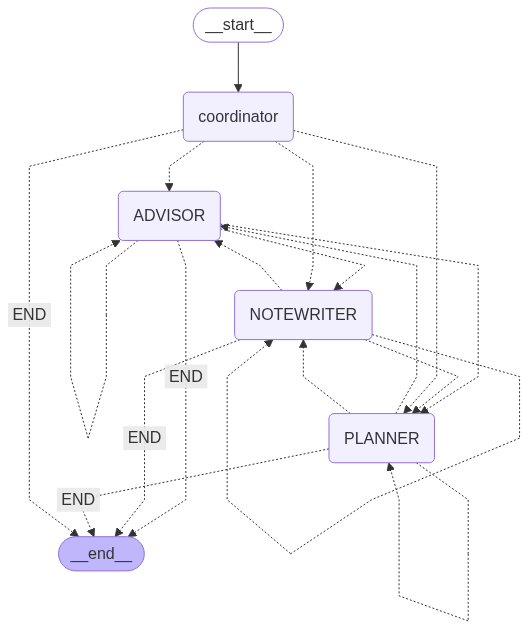

In [26]:
# --- Phần 2: Thiết kế Router V2.0 và Đồ thị chính ---

def router_v2(state: AcademicState) -> Literal["PLANNER", "NOTEWRITER", "ADVISOR", "END"]:
    """
    Router V2.0: Quyết định agent tiếp theo trong chuỗi cần chạy.
    """
    print("\n--- [Router V2.0] Đang quyết định luồng đi tiếp theo... ---")
    required_agents = state.get("results", {}).get("coordinator_analysis", {}).get("required_agents", [])
    completed_keys = state.get("results", {}).keys()

    if "PLANNER" in required_agents and "final_plan" not in completed_keys:
        print(">>> Định tuyến đến PLANNER.")
        return "PLANNER"
    if "NOTEWRITER" in required_agents and "final_notes" not in completed_keys:
        print(">>> Định tuyến đến NOTEWRITER.")
        return "NOTEWRITER"
    if "ADVISOR" in required_agents and "final_advice" not in completed_keys:
        print(">>> Định tuyến đến ADVISOR.")
        return "ADVISOR"
    print(">>> Tất cả các agent được yêu cầu đã chạy xong. Kết thúc.")
    return "END"

# Xây dựng đồ thị chính
workflow_v2 = StateGraph(AcademicState)

# Thêm các nút
workflow_v2.add_node("coordinator", coordinator_agent)
workflow_v2.add_node("PLANNER", planner_subgraph)
workflow_v2.add_node("NOTEWRITER", notewriter_subgraph)
workflow_v2.add_node("ADVISOR", advisor_subgraph)

# Đặt điểm bắt đầu
workflow_v2.set_entry_point("coordinator")

# **SỬA LỖI Ở ĐÂY**
# Chúng ta tạo ra một dictionary chứa tất cả các điểm đến có thể có từ Router
possible_routes = {
    "PLANNER": "PLANNER",
    "NOTEWRITER": "NOTEWRITER",
    "ADVISOR": "ADVISOR",
    "END": END
}

# Sử dụng dictionary `possible_routes` cho tất cả các cạnh điều kiện
workflow_v2.add_conditional_edges("coordinator", router_v2, possible_routes)
workflow_v2.add_conditional_edges("PLANNER", router_v2, possible_routes)
workflow_v2.add_conditional_edges("NOTEWRITER", router_v2, possible_routes)
workflow_v2.add_conditional_edges("ADVISOR", router_v2, possible_routes)


# Biên dịch đồ thị
app_v2 = workflow_v2.compile()
print("\n--- Đồ thị chính ATLAS V2.0 đã được biên dịch thành công! ---")

# Trực quan hóa đồ thị V2.0
try:
    png_data_v2 = app_v2.get_graph().draw_mermaid_png()
    with open("ATLAS_graph_v2.png", "wb") as f:
        f.write(png_data_v2)
    print("Đã lưu sơ đồ workflow V2.0 vào file 'ATLAS_graph_v2.png'")
    display(Image(png_data_v2))
except Exception as e:
    print(f"Không thể tạo sơ đồ workflow: {e}")


In [27]:
# --- Phần 3: Chạy Toàn bộ Hệ thống V2.0 ---

async def run_full_system_v2():
    # Tạo một yêu cầu phức tạp, đòi hỏi cả 3 agent
    request_content = "Tôi có một bài tập lớn AI sắp hết hạn và một kỳ thi vào tuần tới. Hãy giúp tôi tạo một kế hoạch chi tiết, tóm tắt các chủ đề chính của AI, và cho tôi vài lời khuyên để giữ động lực."

    initial_state = {
        "messages": [HumanMessage(content=request_content)],
        "profile": data_manager.get_student_profile("student_123"),
        "calendar": data_manager.calendar_data, # Truyền toàn bộ dữ liệu
        "tasks": data_manager.task_data,       # Truyền toàn bộ dữ liệu
        "results": {}
    }

    console.print("\n" + "="*50, style="bold blue")
    console.print(" BẮT ĐẦU CHẠY HỆ THỐNG ATLAS V2.0 (NÂNG CẤP)", style="bold blue")
    console.print("="*50, style="bold blue")
    console.print(f"\n[bold]Yêu cầu người dùng:[/bold] {request_content}")

    final_state = None
    # Sử dụng astream để theo dõi từng bước của workflow
    async for step in app_v2.astream(initial_state):
        node_name = list(step.keys())[0]
        console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
        final_state = step # Luôn cập nhật trạng thái cuối cùng

    console.print("\n" + "="*50, style="bold green")
    console.print(" HỆ THỐNG ATLAS V2.0 ĐÃ CHẠY XONG!", style="bold green")
    console.print("="*50, style="bold green")

    # In ra tất cả các kết quả cuối cùng một cách đẹp đẽ, có tổ chức
    if final_state:
        # Lấy ra dictionary chứa kết quả từ trạng thái cuối cùng
        results = list(final_state.values())[0]['results']

        console.print("\n\n--- KẾT QUẢ TỔNG HỢP ---")
        if 'final_plan' in results:
            console.print(Panel(Markdown(results['final_plan']['plan_text']), title="[bold green]Kế hoạch được đề xuất[/bold green]", border_style="green", expand=True))
        if 'final_notes' in results:
            console.print(Panel(Markdown(results['final_notes']['notes_text']), title="[bold blue]Ghi chú được tạo[/bold blue]", border_style="blue", expand=True))
        if 'final_advice' in results:
            console.print(Panel(Markdown(results['final_advice']['advice_text']), title="[bold magenta]Lời khuyên chiến lược[/bold magenta]", border_style="magenta", expand=True))

# Chạy hệ thống nếu llm đã được khởi tạo
if llm and 'planner_agent' in locals() and 'notewriter_agent' in locals() and 'advisor_agent' in locals():
    await run_full_system_v2()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì một hoặc nhiều thành phần (llm, agents) chưa được khởi tạo.[/bold red]")

==================================================

 BẮT ĐẦU CHẠY HỆ THỐNG ATLAS V2.0 (NÂNG CẤP)

==================================================

Yêu cầu người dùng: Tôi có một bài tập lớn AI sắp hết hạn và một kỳ thi vào tuần tới. Hãy giúp tôi tạo một kế hoạch
chi tiết, tóm tắt các chủ đề chính của AI, và cho tôi vài lời khuyên để giữ động lực.


--- Bắt đầu chạy Coordinator Agent ---
Gửi yêu cầu đến LLM để phân tích...
Đã nhận phản hồi từ LLM.


Phản hồi thô từ LLM:

{
  "reasoning": "The student needs a detailed plan to manage their time effectively for the upcoming AI assignment 
and exam. They also require a summary of the main AI topics and some advice to stay motivated. The core issue is 
that the student is overwhelmed with multiple tasks and needs guidance on how to prioritize and manage their 
time.",
  "required_agents": ["PLANNER", "NOTEWRITER", "ADVISOR"]
}

Đã phân tích phản hồi thành công.

--- [Router V2.0] Đang quyết định luồng đi tiếp theo... ---
>>> Định tuyến đến PLANNER.


✅ Hoàn thành bước: coordinator


--- [Planner] Bắt đầu phân tích Lịch trình (calendar_analyzer) ---


Phân tích lịch trình: Based on the user's request and the event list, here is a brief analysis:

**Available time slots:**

* August 7-14: No events scheduled, available for studying and working on the AI assignment.
* August 16 and onwards: No events scheduled, available for relaxation and reviewing after the mid-term exam.

**Potential conflicts or busy days:**

* August 6: AI Club Meeting in the evening, may impact study time for the assignment and exam.
* August 15: Mid-term Exam: Algorithms, a critical event that requires focus and preparation.

**Schedule pressure level:**

* Medium: The user has a significant assignment and an exam in the next two weeks, but there are still some 
available time slots for studying and preparation. Effective time management is crucial to meet the deadlines and 
perform well in the exam.

To help the user stay motivated, I would suggest:

* Break down the AI assignment into smaller tasks and create a daily schedule to ensure steady progress.
* Allocate dedicated time for reviewing and practicing algorithms before the mid-term exam.
* Attend the AI Club Meeting to gain new insights and stay engaged with the AI community.
* Take regular breaks to avoid burnout and maintain a healthy work-life balance.


--- [Planner] Bắt đầu phân tích Công việc (task_analyzer) ---


Phân tích công việc: **Phân tích công việc**

Dựa trên danh sách công việc và yêu cầu của người dùng, tôi đưa ra phân tích sau:

**Công việc cần được ưu tiên nhất:** "Submit AI project report" (task_01) với độ ưu tiên cao (high) và hạn chót gần
nhất (2025-08-10T23:59:00Z). Đây là công việc quan trọng nhất cần được hoàn thành trước hạn chót để tránh bị phạt 
điểm hoặc không đạt yêu cầu.

**Mức độ áp lực về công việc:** Cao (High). Với hai công việc quan trọng cần được hoàn thành trong một tuần, người 
dùng cần phải tập trung và quản lý thời gian hiệu quả để hoàn thành công việc.

**Deadline gần nhất cần chú ý:** 2025-08-08T23:59:00Z (task_02) và 2025-08-10T23:59:00Z (task_01). Hai deadline này
rất gần nhau, người dùng cần phải hoàn thành công việc một cách hiệu quả và không được chậm trễ.

**Lời khuyên:** Để giữ động lực, người dùng nên chia nhỏ công việc thành các nhiệm vụ nhỏ hơn, thiết lập các mốc 
thời gian cụ thể và thưởng cho mình sau khi hoàn thành mỗi nhiệm vụ. Ngoài ra, người dùng nên tạo một kế hoạch học 
tập và ôn thi chi tiết để chuẩn bị cho kỳ thi vào tuần tới.


--- [Planner] Bắt đầu tạo Kế hoạch (plan_generator) ---


Kế hoạch cuối cùng đã được tạo:

Here is a detailed and implementable plan for An Nguyen, a 3rd-year Computer Science student:                      

Weekly Plan (August 7-14)                                                                                          

Day 1-2 (August 7-8):                                                                                              

 • Morning (9:00 AM - 12:00 PM): Study AI concepts using visual aids like diagrams, mind maps, and videos. Focus on
   the most critical topics for the mid-term exam.                                                                 
 • Afternoon (1:00 PM - 3:00 PM): Break down the AI project report into smaller tasks. Identify the most critical  
   components and create a daily schedule to ensure steady progress.                                               
 • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                       
 • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                              

Day 3-4 (August 9-10):                                                                                             

 • Morning (9:00 AM - 12:00 PM): Continue working on the AI project report. Focus on one task at a time, and take  
   regular breaks to avoid burnout.                                                                                
 • Afternoon (1:00 PM - 3:00 PM): Attend the AI Club Meeting to gain new insights and stay engaged with the AI     
   community.                                                                                                      
 • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                       
 • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                              

Day 5-6 (August 11-12):                                                                                            

 • Morning (9:00 AM - 12:00 PM): Focus on the most critical topics for the mid-term exam. Use flashcards, concept  
   maps, or other visual aids to reinforce your understanding.                                                     
 • Afternoon (1:00 PM - 3:00 PM): Continue working on the AI project report. Ensure that you are on track to meet  
   the deadline.                                                                                                   
 • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                       
 • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                              

Day 7 (August 13):                                                                                                 

 • Morning (9:00 AM - 12:00 PM): Finalize the AI project report. Ensure that you have completed all tasks and are  
   ready to submit.                                                                                                
 • Afternoon (1:00 PM - 3:00 PM): Review and practice algorithms for the mid-term exam.                            
 • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                       
 • Evening (6:00 PM - 8:00 PM): Relax and recharge for the exam.                                                   

Day 8 (August 14):                                                                                                 

 • Morning (9:00 AM - 12:00 PM): Review and practice algorithms for the mid-term exam.                             
 • Afternoon (1:00 PM - 3:00 PM): Take a break and relax before the exam.                                          

Exam Day (August 15):                                                                                              

 • Morning (9:00 AM - 12:00 PM): Take the mid-term exam.                                                           

Strategies to stay motivated:             


--- [Router V2.0] Đang quyết định luồng đi tiếp theo... ---
>>> Định tuyến đến NOTEWRITER.


✅ Hoàn thành bước: PLANNER


--- [NoteWriter] Bắt đầu phân tích Phong cách học tập ---


Phân tích phong cách học tập: Based on the student's profile and requirements, I would recommend the following:

**Most suitable note-taking method:** Mind Map

The student's visual learning style and preference for diagrams, mind maps, and videos suggest that a mind map 
would be an effective way to organize and review AI concepts. Mind maps allow for visual representation of 
relationships between ideas, making it easier to connect and retain information.

**Key focus areas for creating notes:**

1. **Visualize relationships**: Use mind maps to illustrate the connections between AI concepts, such as machine 
learning, deep learning, and neural networks.
2. **Break down complex topics**: Divide larger topics into smaller, manageable chunks, and use visual aids like 
diagrams and flowcharts to explain complex ideas.
3. **Use concise labels and keywords**: Use brief labels and keywords to identify key concepts, making it easier to
review and recall information.
4. **Incorporate images and videos**: Include relevant images, videos, or animations to supplement text-based 
information and enhance understanding.
5. **Create a hierarchical structure**: Organize notes using a hierarchical structure, with main topics branching 
out into subtopics, to help the student see the big picture.

By using a mind map approach, the student will be able to visually organize and review AI concepts, making it 
easier to prepare for the upcoming exam and complete the assignment.


--- [NoteWriter] Bắt đầu tạo Ghi chú ---


Ghi chú cuối cùng đã được tạo:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                             AI Study Plan and Notes                                             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                     Overview                                                      

 • Upcoming Exam: Review key concepts and topics in Artificial Intelligence (AI)                                   
 • Assignment: Complete a large AI project with a nearing deadline                                                 


                                                Mind Map Structure                                                 

                                                 Machine Learning                                                  

 • Supervised Learning                                                                                             
    • Regression                                                                                                   
    • Classification                                                                                               
 • Unsupervised Learning                                                                                           
    • Clustering                                                                                                   
    • Dimensionality Reduction                                                                                     
 • Reinforcement Learning                                                                                          
    • Markov Decision Processes                                                                                    
    • Q-Learning                                                                                                   

                                                   Deep Learning                                                   

 • Neural Networks                                                                                                 
    • Feedforward Networks                                                                                         
    • Convolutional Neural Networks (CNNs)                                                                         
    • Recurrent Neural Networks (RNNs)                                                                             
 • Deep Learning Architectures                                                                                     
    • Autoencoders                                                                                                 
    • Generative Adversarial Networks (GANs)                                                                       

                                                  AI Applications                                                  

 • Computer Vision                                                                                                 
    • Image Processing                                                                                             
    • Object Detection                                                                                             
 • Natural Language Processing (NLP)                                                                               
    • Text Processing                                                                                              
    • Sentiment Analysis                                                                                           


                                             Key Concepts and Formulas                                             

 • Bias-Variance Tradeoff                                                                                          
 • Overfitting and Underfitting           


--- [Router V2.0] Đang quyết định luồng đi tiếp theo... ---
>>> Định tuyến đến ADVISOR.


✅ Hoàn thành bước: NOTEWRITER


--- [Advisor] Bắt đầu phân tích Tình hình ---


Phân tích tình hình: Based on the provided context, I identify the following core challenges that the student, An 
Nguyen, is facing:

1. **Time management**: An has a large AI project report to complete and a mid-term exam to prepare for, with a 
nearing deadline, which can lead to time management issues and potential burnout.
2. **Information overload**: The AI subject matter is vast and complex, with many topics to cover, including 
machine learning, deep learning, and AI applications, which can be overwhelming for the student.
3. **Motivation and focus**: An needs to stay motivated and focused to complete the project report and prepare for 
the exam, which can be challenging, especially with the pressure of an upcoming deadline.
4. **Balancing study and other activities**: An needs to balance studying with other activities, such as attending 
the AI Club Meeting, relaxation, and self-care, to avoid burnout and maintain overall well-being.
5. **Organizational skills**: An needs to develop effective organizational skills to break down complex topics into
manageable chunks, prioritize tasks, and stay on track to meet the deadline.

By addressing these core challenges, An can develop a more effective learning plan, stay motivated, and achieve 
success in completing the project report and acing the mid-term exam.


--- [Advisor] Bắt đầu tạo Lời khuyên ---


Lời khuyên cuối cùng đã được tạo:

An Nguyen, I completely understand the pressure you're under with that looming deadline and mid-term exam. But fear
not, my friend, for I'm here to offer you a strategic plan to tackle this beast of a project and exam, while       
keeping your motivation and focus intact.                                                                          

Embrace the Power of Breakdown                                                                                     

First, let's break down the massive AI project into manageable chunks. Create a mind map or an outline to visualize
the key topics, such as machine learning, deep learning, and AI applications. This will help you identify the most 
critical areas to focus on and allocate your time wisely.                                                          

Active Recall and Spaced Repetition: Your Memory Superpowers                                                       

To combat information overload, employ active recall techniques, like summarizing notes in your own words, creating
concept maps, or making flashcards. This will help solidify the information in your long-term memory. Additionally,
use spaced repetition to review material at increasingly longer intervals, ensuring that the knowledge sticks.     

The Pomodoro Technique: Your Time Management Savior                                                                

To avoid burnout, work in focused 25-minute increments, followed by a 5-minute break. This technique will help you 
stay on track, maintain energy levels, and make the most of your study time. After four cycles, take a longer break
of 15-30 minutes to recharge.                                                                                      

Motivation and Focus: Your Inner Coach                                                                             

When faced with procrastination, ask yourself: "What's the smallest, most manageable task I can complete right     
now?" Celebrate each small victory, and use that momentum to propel yourself forward. Remind yourself why you're   
working on this project and how it will benefit your future.                                                       

The Power of Reflection and Adjustment                                                                             

Regularly reflect on your progress, identifying what's working and what areas need improvement. Adjust your plan   
accordingly, making sure you're allocating time and energy to the most critical tasks.                             

Self-Care and Balance: Your Well-being Guardians                                                                   

Don't forget to schedule time for relaxation, self-care, and other activities, like attending the AI Club Meeting. 
A well-rounded routine will help you maintain your physical and mental well-being, ensuring you're at your best    
when tackling the project and exam.                                                                                

Your AI Project Report Blueprint                                                                                   

Create a detailed outline for your project report, breaking it down into smaller sections and tasks. Set specific  
goals for each study session, and use a timer to keep yourself on track.                                           

Final Tips and Reminders                                                                                           

 • Set realistic goals and deadlines for yourself, and be kind when you encounter setbacks.                        
 • Use your mistakes as opportunities to learn and grow.                                                           
 • Keep your study space organized and clutter-free to reduce distractions.                                        
 • Reward yourself for milestones achieved and progress made.                                                      

An, my friend, by incorporating these s


--- [Router V2.0] Đang quyết định luồng đi tiếp theo... ---
>>> Tất cả các agent được yêu cầu đã chạy xong. Kết thúc.


✅ Hoàn thành bước: ADVISOR

==================================================

 HỆ THỐNG ATLAS V2.0 ĐÃ CHẠY XONG!

==================================================

--- KẾT QUẢ TỔNG HỢP ---

╭───────────────────────────────────────────── Kế hoạch được đề xuất ─────────────────────────────────────────────╮
│ Here is a detailed and implementable plan for An Nguyen, a 3rd-year Computer Science student:                   │
│                                                                                                                 │
│ Weekly Plan (August 7-14)                                                                                       │
│                                                                                                                 │
│ Day 1-2 (August 7-8):                                                                                           │
│                                                                                                                 │
│  • Morning (9:00 AM - 12:00 PM): Study AI concepts using visual aids like diagrams, mind maps, and videos.      │
│    Focus on the most critical topics for the mid-term exam.                                                     │
│  • Afternoon (1:00 PM - 3:00 PM): Break down the AI project report into smaller tasks. Identify the most        │
│    critical components and create a daily schedule to ensure steady progress.                                   │
│  • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                    │
│  • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                           │
│                                                                                                                 │
│ Day 3-4 (August 9-10):                                                                                          │
│                                                                                                                 │
│  • Morning (9:00 AM - 12:00 PM): Continue working on the AI project report. Focus on one task at a time, and    │
│    take regular breaks to avoid burnout.                                                                        │
│  • Afternoon (1:00 PM - 3:00 PM): Attend the AI Club Meeting to gain new insights and stay engaged with the AI  │
│    community.                                                                                                   │
│  • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                    │
│  • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                           │
│                                                                                                                 │
│ Day 5-6 (August 11-12):                                                                                         │
│                                                                                                                 │
│  • Morning (9:00 AM - 12:00 PM): Focus on the most critical topics for the mid-term exam. Use flashcards,       │
│    concept maps, or other visual aids to reinforce your understanding.                                          │
│  • Afternoon (1:00 PM - 3:00 PM): Continue working on the AI project report. Ensure that you are on track to    │
│    meet the deadline.                                                                                           │
│  • Break time (3:00 PM - 3:30 PM): Take a short break to relax and recharge.                                    │
│  • Evening (6:00 PM - 8:00 PM): Review and practice algorithms for the mid-term exam.                           │
│                                                                                                                 │
│ Day 7 (August 13):                                                                                              │
│                                                                                                                 │
│  • Morning (9:00 AM - 12:00 PM): Finalize the AI proje

╭─────────────────────────────────────────────── Ghi chú được tạo ────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ │
│ ┃                                           AI Study Plan and Notes                                           ┃ │
│ ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛ │
│                                                                                                                 │
│                                                                                                                 │
│                                                    Overview                                                     │
│                                                                                                                 │
│  • Upcoming Exam: Review key concepts and topics in Artificial Intelligence (AI)                                │
│  • Assignment: Complete a large AI project with a nearing deadline                                              │
│                                                                                                                 │
│                                                                                                                 │
│                                               Mind Map Structure                                                │
│                                                                                                                 │
│                                                Machine Learning                                                 │
│                                                                                                                 │
│  • Supervised Learning                                                                                          │
│     • Regression                                                                                                │
│     • Classification                                                                                            │
│  • Unsupervised Learning                                                                                        │
│     • Clustering                                                                                                │
│     • Dimensionality Reduction                                                                                  │
│  • Reinforcement Learning                                                                                       │
│     • Markov Decision Processes                                                                                 │
│     • Q-Learning                                                                                                │
│                                                                                                                 │
│                                                  Deep Learning                                                  │
│                                                                                                                 │
│  • Neural Networks                                                                                              │
│     • Feedforward Networks                                                                                      │
│     • Convolutional Neural Networks (CNNs)                                                                      │
│     • Recurrent Neural Networks (RNNs)                                                                          │
│  • Deep Learning Architectures                                                                                  │
│     • Autoencoders                                                                                              │
│     • Generative Adversarial Networks (GANs)          

╭───────────────────────────────────────────── Lời khuyên chiến lược ─────────────────────────────────────────────╮
│ An Nguyen, I completely understand the pressure you're under with that looming deadline and mid-term exam. But  │
│ fear not, my friend, for I'm here to offer you a strategic plan to tackle this beast of a project and exam,     │
│ while keeping your motivation and focus intact.                                                                 │
│                                                                                                                 │
│ Embrace the Power of Breakdown                                                                                  │
│                                                                                                                 │
│ First, let's break down the massive AI project into manageable chunks. Create a mind map or an outline to       │
│ visualize the key topics, such as machine learning, deep learning, and AI applications. This will help you      │
│ identify the most critical areas to focus on and allocate your time wisely.                                     │
│                                                                                                                 │
│ Active Recall and Spaced Repetition: Your Memory Superpowers                                                    │
│                                                                                                                 │
│ To combat information overload, employ active recall techniques, like summarizing notes in your own words,      │
│ creating concept maps, or making flashcards. This will help solidify the information in your long-term memory.  │
│ Additionally, use spaced repetition to review material at increasingly longer intervals, ensuring that the      │
│ knowledge sticks.                                                                                               │
│                                                                                                                 │
│ The Pomodoro Technique: Your Time Management Savior                                                             │
│                                                                                                                 │
│ To avoid burnout, work in focused 25-minute increments, followed by a 5-minute break. This technique will help  │
│ you stay on track, maintain energy levels, and make the most of your study time. After four cycles, take a      │
│ longer break of 15-30 minutes to recharge.                                                                      │
│                                                                                                                 │
│ Motivation and Focus: Your Inner Coach                                                                          │
│                                                                                                                 │
│ When faced with procrastination, ask yourself: "What's the smallest, most manageable task I can complete right  │
│ now?" Celebrate each small victory, and use that momentum to propel yourself forward. Remind yourself why       │
│ you're working on this project and how it will benefit your future.                                             │
│                                                                                                                 │
│ The Power of Reflection and Adjustment                                                                          │
│                                                                                                                 │
│ Regularly reflect on your progress, identifying what's working and what areas need improvement. Adjust your     │
│ plan accordingly, making sure you're allocating time and energy to the most critical tasks.                     │
│                                                       